## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

## Importing Dataset

In [2]:
df = pd.read_csv('creditcard.csv')

## Scaling

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler
sc = StandardScaler()
rc = RobustScaler()

df['scaled_amount'] = rc.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rc.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

## Examine Fraudulent Transactions

In [4]:
print('Non Frauds: ', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds: ', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Non Frauds:  99.83 % of the dataset
Frauds:  0.17 % of the dataset


## Balance Dataset

In [5]:
# Shuffle dataset to implement random undersampling 
df = df.sample(frac=1)
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]   # 492 amount of fraud transaction 
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
random_undersample_df = normal_distributed_df.sample(frac=1, random_state=42)


## Implement Random Undersampling

In [6]:
from sklearn.model_selection import train_test_split
from copy import deepcopy


X = random_undersample_df.drop('Class', axis=1)
y = random_undersample_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn to arrays to feed on classifier (Random Forest Algorithm)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

X_train2 = deepcopy(X_train)
X_test2 = deepcopy(X_test)
y_train2 = deepcopy(y_train)
y_test2 = deepcopy(y_test)

## Get The Best Parameters For Random Forest Classifier

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7]}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

## Train the Random Forest Model on the Training Set

In [8]:
rf_classifier = RandomForestClassifier(**best_params)
rf_classifier.fit(X_train,y_train)

y_pred = rf_classifier.predict(X_test)

## Evaluate the Model's Performance 

In [9]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef

acc = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
mcc =matthews_corrcoef(y_test,y_pred)

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Matthews correlation coefficient: {mcc}")


Accuracy: 0.934010152284264
Precision: 0.98989898989899
Recall: 0.8909090909090909
F1-Score: 0.937799043062201
Matthews correlation coefficient: 0.8734119362123363


## Compare to Single Decision Tree Classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier 
 
# Define hyperparameter grid 
tree_params = {"criterion": ["gini", "entropy"], 
"max_depth": list(range(2,4,1)),  
"min_samples_leaf": list(range(5,7,1))} 
 
grid_tree = GridSearchCV(DecisionTreeClassifier(), 
tree_params) 
grid_tree.fit(X_train2, y_train2) 
 
# Get the best parameters for the balanced dataset 
tree_clf = grid_tree.best_estimator_ 
 
# Train balanced dataset with Decision Tree Model 
dt_classifier = tree_clf 
dt_classifier.fit(X_train2,y_train2) 
 
# New prediction 
new_y_pred = dt_classifier.predict(X_test2) 
 
# Verdict 
acc = accuracy_score(y_test2,new_y_pred) 
precision = precision_score(y_test2,new_y_pred) 
recall = recall_score(y_test2,new_y_pred) 
f1 = f1_score(y_test2,new_y_pred) 
mcc =matthews_corrcoef(y_test2,new_y_pred) 
 
print(f"Accuracy: {acc}") 
print(f"Precision: {precision}") 
print(f"Recall: {recall}") 
print(f"F1-Score: {f1}") 
print(f"Matthews correlation coefficient: {mcc}")

Accuracy: 0.9137055837563451
Precision: 1.0
Recall: 0.8454545454545455
F1-Score: 0.916256157635468
Matthews correlation coefficient: 0.8409846875866674


## The Confusion Matrix

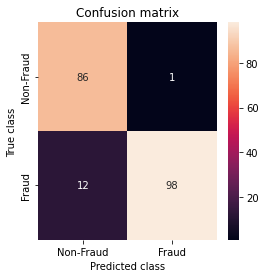

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
LABELS = ['Non-Fraud', 'Fraud']
confusion_mtx = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_mtx, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig("confusion_matrix")
plt.show()